# Проект: вариант 2
**Задание 1. A/B–тестирование**
В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

from scipy.stats import chi2_contingency, norm

from tqdm.auto import tqdm
import pandahouse as ph

plt.style.use('ggplot')

Логика такова: имеется 4 дата-сета (groups и group_add с разделением на А/B группы, active_students - участники эксперимента, checks - участники, которые произвели оплаты). Нас интересуют непосредственно участники эксперимента (пользователи зашедшие на платформу в дни эксперимента и из них уже делим на группы А/B, за метрику "успешности" эксперимента берём оплату (брать больше и нечего), а именно: CR, ARPU, ARPPU, так как нас интересует стали ли больше покупать что бы мы там не продавали (конверсия в покупку) и приносит это нам большую прибыль или нет (средний чек на акт. пользователя и средний чек на платящего пользователя). 

In [2]:
# файл с инф-цией о принадлежности пользователя к группе (А – контроль, B – целевая группа) 
groups = pd.read_csv('Проект_2_groups.csv', sep=";")
groups[:3]

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [3]:
groups.shape

(74484, 2)

In [4]:
# дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
group_add = pd.read_csv('Проект_2_group_add.csv')
group_add[:3]

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B


In [5]:
group_add.shape

(92, 2)

In [6]:
# сразу coединим дата-сеты
final_groups = pd.concat([groups, group_add])

In [7]:
final_groups.shape

(74576, 2)

In [8]:
# проверим id на уникальность -> всё хорошо 
final_groups.id.nunique()

74576

In [9]:
# пропусков нет 
final_groups.isna().sum()

id     0
grp    0
dtype: int64

In [10]:
# файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента
active_students = pd.read_csv('Проект_2_active_studs.csv')
active_students[:3]

,student_id
0,581585
1,5723133
2,3276743


In [11]:
active_students.shape

(8341, 1)

In [12]:
active_students.student_id.nunique()

8341

In [13]:
active_students.isna().sum()

student_id    0
dtype: int64

In [14]:
# файл с информацией об оплатах пользователей в дни проведения эксперимента
checks = pd.read_csv('Проект_2_checks.csv', sep=";")
checks[:3]

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


In [15]:
checks.shape

(541, 2)

In [16]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

Пропущенных значений в датасетах нет, все значения ID уникальны

In [17]:
active_students['active'] = 1

In [18]:
# мерджим активных пользователех с платниками
act_checks = active_students.merge(checks, how='outer', on='student_id') \
    .rename(columns={"student_id": "id", "rev": "payment"}) 

In [19]:
full_data = act_checks.merge(final_groups, on='id', how='outer') \
    .fillna(0)  # заменим пропущенные значение на 0

In [20]:
full_data[:2]

,id,active,payment,grp
0,581585,1.0,0.0,A
1,5723133,1.0,0.0,A


In [21]:
# проверяем типы данных 
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74576 entries, 0 to 74575
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       74576 non-null  int64  
 1   active   74576 non-null  float64
 2   payment  74576 non-null  float64
 3   grp      74576 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 2.8+ MB


In [22]:
# зададим значения, где наличие покупки -> 1, отсутвие покупки -> 0
full_data['purchase'] = np.where(full_data.payment > 0, 1, 0)

In [23]:
full_data = full_data[['id', 
                       'grp', 
                       'payment',
                       'active',
                       'purchase']]

In [24]:
# оплатили и участвовали в эксперименте 
full_data.query('payment > 0 & active == 1').shape[0]

392

In [25]:
# не совершали покупку и участвовали в эксперименте 
full_data.query('payment == 0 & active == 1').shape[0]

7949

In [26]:
# оплатили и не учавствовали в эксперименте
full_data.query('payment > 0 & active == 0').shape[0]

149

In [27]:
# не оплатили и не учавствовали в эксперименте
full_data.query('payment == 0 & active == 0').shape[0]

66086

В первую очередь нас интересуют участники эксперимента, но мы наблюдаем наличие 149 пользователя, которые произвели оплату, но не заходили на платформу, это мог быть автоплатеж или баг и они на самом деле были активные, но так как у нас нет никакой информации помимо преложенных df, то мы не будем включать этих пользователей для дальнейшего исследования.

In [28]:
# формируем  дата-сет с которым будем работать в дальнейшем
data_active = full_data.query('active == 1')

In [29]:
# смотрим какое распределение по группам 
data_active.grp.value_counts()

B    6803
A    1538
Name: grp, dtype: int64

In [30]:
# можно заметить дисбаланс в выборках (≈20/80)
data_active.grp.value_counts(normalize=True)

B    0.81561
A    0.18439
Name: grp, dtype: float64

In [31]:
# распределение по группам среди платящих пользователей 
data_active.query('payment > 0').grp.value_counts()

B    314
A     78
Name: grp, dtype: int64

In [32]:
# картина схожая 
data_active.query('payment > 0').grp.value_counts(normalize=True)

B    0.80102
A    0.19898
Name: grp, dtype: float64

In [33]:
data_active.query('payment > 0 & grp == "A"').payment.value_counts()

290.0     25
580.0      6
990.0      5
590.0      5
199.0      5
690.0      4
1530.0     3
3660.0     3
840.0      3
1140.0     2
489.0      2
1160.0     2
2820.0     2
2910.0     2
2890.0     1
1180.0     1
2900.0     1
1830.0     1
2220.0     1
870.0      1
398.0      1
1980.0     1
1039.0     1
Name: payment, dtype: int64

In [34]:
data_active.query('payment > 0 & grp == "B"').payment.value_counts()

1900.0000    93
290.0000     45
1900.0001    35
199.0000     27
840.0000     21
990.0000     17
690.0000     13
1140.0000     9
590.0000      6
398.0000      6
870.0000      5
580.0000      5
1530.0000     5
2890.0000     3
2099.0000     3
1980.0000     2
3660.0000     2
2910.0000     2
796.0000      1
1388.0000     1
489.0000      1
1160.0000     1
2190.0000     1
3040.0000     1
1968.0000     1
880.0000      1
1729.0000     1
2220.0000     1
1339.0000     1
4650.0000     1
1050.0000     1
597.0000      1
3260.0000     1
Name: payment, dtype: int64

Перейдем непосредсвенно к метрикам: 

### CR

**Conversion rate, CR** — отношение числа пользователей, которые выполнили какое-либо целевое действие к общему числу пользователей. CR - метрика категориальная, то есть пользователь либо произвел оплату (1), либо нет (2), поэтому для проверки гипотезы выберем тест - хи-квадрат.

### Гипотеза (CR): 

H0 - Конверсии контольной и тестовой (целевой) групп статистически не различаются.

H1 - Конверсии имеются статистически значимые различия между контольной и тестовой группами.

In [35]:
a_group = data_active.query('grp=="A"')
b_group = data_active.query('grp=="B"')

In [36]:
# расчитываем конверсию в покупку внутри групп 
cr_a = round(a_group.query('payment > 0').id.count() / a_group.id.count(), 3)
cr_b = round(b_group.query('payment > 0').id.count() / b_group.id.count(), 3)
diff_cr = round((cr_a / cr_b-1) * 100, 2)
print(f'CR для контрольной группы {cr_a}!')
print(f'CR для целевой группы {cr_b}!')
print(f'Конверсия в покупку у контрольной группы больше, чем у тестовой на {diff_cr}%!')

CR для контрольной группы 0.051!
CR для целевой группы 0.046!
Конверсия в покупку у контрольной группы больше, чем у тестовой на 10.87%!


In [37]:
# перегруппируем 
data_active_crosstab = pd.crosstab(data_active.grp, data_active.purchase)
data_active_crosstab

purchase,0,1
grp,,
A,1460,78
B,6489,314


In [38]:
stat, p_chi, dof, expected = chi2_contingency(data_active_crosstab)
p_chi = p_chi.round(3)
print(f'P-value {p_chi} > 0.05, т.e. cтатистически значимых различий конверсий между экспериментальной и контрольной групп \nне наблюдается. Принимаем H0!')

P-value 0.486 > 0.05, т.e. cтатистически значимых различий конверсий между экспериментальной и контрольной групп 
не наблюдается. Принимаем H0!


Теперь перейдем к колличественным метрикам.

In [42]:
paying_users = data_active.query('payment > 0')

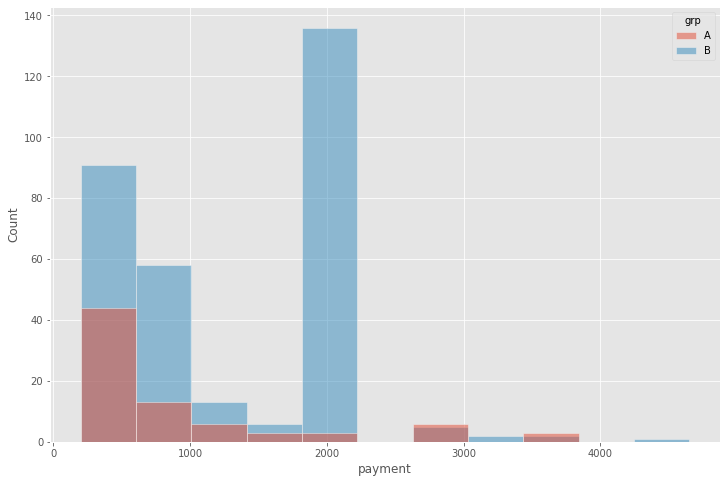

In [49]:
# контрольная и целевая группы
plt.figure(figsize=(12, 8))
sns.histplot(data=paying_users, x='payment', hue='grp')

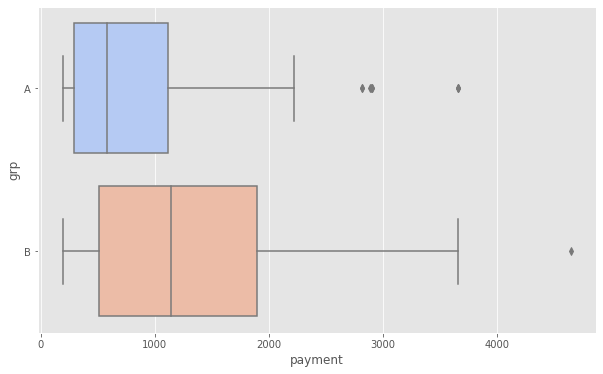

In [50]:
# по боксплоту можно заметить, что пользователи группы B совершают больше оплат на бОльшую сумму
# но явлеются ли различия стат. значимыми определим позже
plt.figure(figsize=(10, 6))
sns.boxplot(x='payment', y='grp', data=paying_users, palette='coolwarm')

### Выбор теста

**Т-тест** отклоняем из-за маленького количества наблюдений в выборках с явно ненормальным распределением.

Не смотря на то, что **критерий Манна-Уитни** устойчив к выбросам, которые наблюдаются в наших выборках, но для проверки гипотез о равенстве средних данный критерий не подходит из-за специфики работы самого критерия (условно "благосклонно" влияет на пользователей с мелкой выручкой и не очень на пользователей с большой выручкой из-за большого кол-ва повторяющихся значений, что может привести к некорректным результатам). 

Остается **Bootstrap**. Бутстрап — это универсальный стат. метод, когда еще бесконечно-вечные тайны статистики не освоены, а метод выбрать надо. Главный недостаток - это скорость обработки, но наши условно небольшие выборки позволяют его использовать. Тем не менее, выбор именно этого критерия был обусловлен дисбалансом в наших выборках и их размером.

### ARPU
**ARPU** - средний платеж на всех активных пользователей. 

### Гипотеза для ARPU:
Н0: Разница между ARPU в тестовой и контрольной группе отсутствует.

Н1: Разница между ARPU в тестовой и контрольной группе статистически значима.

In [ ]:
arpu_a = round(a_group.payment.sum() / a_group.agg({'id':'count'})[0], 2)
arpu_b = round(b_group.payment.sum() / b_group.agg({'id':'count'})[0], 2)
diff_arpu = round((arpu_b/arpu_a-1) * 100, 2)
print(f'ARPU для контрольной группы {arpu_a}!')
print(f'ARPU для целевой группы {arpu_b}!')
print(f'Средний чек на акт. пользователя увеличился на {diff_arpu}%!')

In [ ]:
def get_bootstrap(
    data_column_1, # firts sample values
    data_column_2, # second sample values
    boot_it = 1000, # number of bootstrap subsamples
    statistic = np.mean, # statistics we need
    bootstrap_conf_level = 0.95 # confidence level
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # taking subsamples
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # using statistic function
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [ ]:
booted_data_arpu = get_bootstrap(a_group.payment, b_group.payment)

In [ ]:
booted_data_arpu["p_value"] # альфа

In [ ]:
print(f'P-value {round(booted_data_arpu["p_value"], 4)} < 0.05, отклоняем H0, наблюдаются стат. значимые различия arpu между группами!')

**ARPPU** - cредний платеж на всех платящих пользователей.

### Гипотеза для ARPPU:
Н0: Разница между ARPPU в тестовой и контрольной группе отсутствует.

Н1: Разница между ARPPU в тестовой и контрольной группе статистически значима.

In [ ]:
arppu_a = round(a_group.payment.sum() / a_group.query('payment > 0').agg({'id':'count'})[0], 2)
arppu_b = round(b_group.payment.sum() / b_group.query('payment > 0').agg({'id':'count'})[0], 2)
diff_arppu = round((arppu_b/arppu_a - 1) * 100, 2)
print(f'ARPPU для контрольной группы {arppu_a}!')
print(f'ARPPU для целевой группы {arppu_b}!')
print(f'Средний чек платящих пользователей увеличился на {diff_arppu}%!')

In [ ]:
booted_data_arppu = get_bootstrap(paying_users.query("grp == 'B'").payment, paying_users.query("grp == 'A'").payment)

In [ ]:
booted_data_arppu["p_value"] # альфа

In [ ]:
print(f'P-value {round(booted_data_arppu["p_value"], 4)} < 0.05, отклоняем H0, наблюдаются стат. значимые различия arpu между группами!')

**Update**: t-test в данном случае вполне применим, т.к распределение разниц между группами при Bootstrap было близко к нормальному -> ЦПР вполне себе работает (но это не точно) -> применение теста будет уместным.

### Выводы:

- Конверсия в покупку у контрольной группы больше чем у тестовой на 10.87% и это изменение статистически не значимо. 
- Средний чек на акт. пользователя увеличился на 22.62%, измения являются статистически значимыми.
- Средний чек платящих пользователей увеличился на 34.74%, это изменение статистически значимо.

Таким образом, переходов активных пользователей в покупку больше не стало, но, при этом, пользователи стали чаще оплачивать более дорогостоящие услуги -> выручка выросла как на активного пользователя, так и на платящего, что для бизнеса всегда хорошо, хотя для тестирования механики новой оплаты важнее всё-таки конверсия. 

В идеале, я бы сначала уточнила несколько моментов, т.к. были замечены некоторые ошибки: не все платящие считались активными, наблюдались значительные выбросы в оплатах (а имеенно большое кол-во оплат  на определенную сумму - 1900 р) и наличие дисбаланса в распределении между выборками (test - 80%, control - 20%, что уже необычно, перепутали группы или обратный аб тест?), что не является проблемой, когда выборки объемные, но, например, при тестировании arppu, наблюдений было достаточно мало. 

Если ошибки подтверждаются, то с выкатом необходимо повременить, сначала устранить ошибки и провести повторный тест.

### Задание 2. SQL
2.1 Очень усердные ученики.
Так в таблице данные предтсавлены только за одни сутки, а условие задачи показать кол-во усердный учеников за месяц, то делаем вид, что все данные есть. 

In [ ]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'}

In [ ]:
connection_test = dict(database='test',
                  host='http://clickhouse.beslan.pro:8080',
                  user='student-rw',
                  password='656e2b0c9c')

In [ ]:
query = """
--select min(timest),
--max(timest) from default.peas
SELECT COUNTIF(DISTINCT st_id, solved_tasks >= 20) as diligent_students FROM
    (
    SELECT SUM(correct) as solved_tasks,
    st_id
    FROM default.peas
    WHERE DATE_TRUNC('month', timest) = '2020-03-01'
    GROUP BY st_id
    )
"""
df_1 = ph.read_clickhouse(query, connection=connection_default)

In [ ]:
df_1

### 2.2 Оптимизация воронки

In [ ]:
query = """
with active as (
SELECT
    distinct st_id AS st_id,
    sum(correct) > 10 AS active,
    sumIf(correct, subject = 'Math') >= 2 AS math_active
FROM
    default.peas
GROUP BY
    st_id)
SELECT
test_grp,
revenue / all_students as arpu, -- ARPU 
active_revenue / active_students as arpau, -- ARPAU
pay_students / all_students * 100 as cr, -- CR в покупку
pay_active_students / active_students * 100 as cr_active, -- СR активного пользователя в покупку 
math_act_pay_students / math_active_students * 100 as cr_math -- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
FROM (
    SELECT 
    count(DISTINCT st.st_id) as all_students, -- все студенты
    sum(f.money) as revenue, -- выручка
    countIf(DISTINCT st.st_id, f.money > 0) as pay_students, -- платящие студенты 
    countIf(DISTINCT st.st_id, a.active = 1) as active_students, -- активные студенты (>10 задач)
    sumIf(f.money, a.active = 1) as active_revenue, -- выручка активных студентов
    countIf(DISTINCT st.st_id, a.active = 1 and f.money > 0) as pay_active_students, -- активные платящие студенты
    countIf(DISTINCT st.st_id, math_active = 1) as math_active_students, -- активные в математике
    countIf(DISTINCT st.st_id, math_active = 1 and f.money > 0 and f.subject = 'Math') as math_act_pay_students, 
    test_grp
    FROM default.studs as st
    LEFT JOIN active as a
    ON st.st_id = a.st_id
    LEFT JOIN default.final_project_check as f 
    ON a.st_id = f.st_id
    group by test_grp
    )
"""
df_2 = ph.read_clickhouse(query, connection=connection_default)

In [ ]:
df_2.round(2)

### 3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [ ]:
# Функция импортирует данные из файл в копию указанного датафрейма и возвращает новый.
def concat_from_filename(df, filename, opts):
    sep = opts.get('sep', ';') #разделитель данных CSV
    col_id = opts.get('id', '') #название колонки id
    col_group = opts.get('group', '') #название колонки grp

    df2 = pd.read_csv(filename, sep=sep, usecols=[ col_id, col_group ]) 
    result = pd.concat([df, df2], ignore_index=True) 
    return result

In [ ]:
def metrics(
      group_add,  # dataframe
      groups_fn='Проект_2_groups.csv', 
      active_stud_fn='Проект_2_active_studs.csv',
      checks_fn='Проект_2_checks.csv',
):

    final_groups = pd.concat([groups, group_add]) 
    act_checks = active_students.merge(
        checks, 
        how='left', 
        on='student_id')\
    .rename(columns={"student_id": "id", "grp" : "group", "rev" : "payment"})
    
    data_active = act_checks.merge(
        final_groups, 
        on='id', 
        how='left').fillna(0) 
    # cформируем группы
    a_group = data_active.query('grp=="A"')
    b_group = data_active.query('grp=="B"')
    
    #CR
    cr_a = round(a_group.query('payment > 0').id.count() / a_group.id.count(), 3)
    cr_b = round(b_group.query('payment > 0').id.count() / b_group.id.count(), 3)
    
    #ARPU
    #paying_users = data_active.query('payment > 0')
    arpu_a = round(a_group.payment.sum() / a_group.agg({'id':'count'})[0], 2)
    arpu_b = round(b_group.payment.sum() / b_group.agg({'id':'count'})[0], 2)
    
    #ARPPU
    arppu_a = round(a_group.payment.sum() / a_group.query('payment > 0').agg({'id' : 'count'})[0], 2)
    arppu_b = round(b_group.payment.sum() / b_group.query('payment > 0').agg({'id' : 'count'})[0], 2)
    
    df = {
        'grp': ['a_group', 'b_group'], 
        'CR': [cr_a, cr_b], 
        'ARPU': [arpu_a, arpu_b], 
        'ARPPU': [arppu_a, arppu_b],
    }
    
    return pd.DataFrame(data = df)

In [ ]:
def metrics_charts(df):
    fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (11, 12))
    sns.boxplot(x=paying_users['payment'], y=paying_users['grp'], ax = ax[1][1], palette = 'coolwarm').set_title('Payment Distribution')
    sns.barplot(x=df['grp'], y=df['CR'], ax=ax[0][0], palette='coolwarm').set_title('CR')
    sns.barplot(x=df['grp'], y=df['ARPU'], ax=ax[0][1], palette='coolwarm').set_title('ARPU')
    sns.barplot(x=df['grp'], y=df['ARPPU'], ax=ax[1][0], palette='coolwarm').set_title('ARPPU') 

In [ ]:
# загружает group_add и джойним с groups возвращая новый объект dataframe
grp_add_df = concat_from_filename(groups, "Проект_2_group_add.csv", dict(
  id="id",
  group="grp",
  sep=",",
))

result = metrics(grp_add_df)

print(result)

metrics_charts(result)